<a href="https://colab.research.google.com/github/JaeHeee/Pytorch_Tutorial/blob/main/code/WHAT_IS_TORCH_NN_REALLY%3F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## WHAT IS TORCH.NN REALLY?

### MNIST data setup

In [ ]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "http://deeplearning.net/data/mnist/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

In [ ]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

(50000, 784)


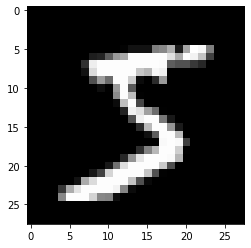

In [ ]:
from matplotlib import pyplot
import numpy as np

pyplot.imshow(x_train[0].reshape((28, 28)), cmap="gray")
print(x_train.shape)

In [ ]:
import torch

x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)

n, c = x_train.shape
x_train, x_train.shape, y_train.min(), y_train.max()

print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


### Neural net from scratch (no torch.nn)

We are initializing the weights here with Xavier initialisation (by multiplying with 1/sqrt(n)).

In [ ]:
import math

weights = torch.randn(784, 10) / math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

In [ ]:
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)

# @ stands for the dot product operation.
def model(xb):
    return log_softmax(xb @ weights + bias)

In [ ]:
bs = 64 # batch_size

xb = x_train[0:bs] # x로부터 mini-batch 추출
preds = model(xb) # prediction
preds[0], preds.shape
print(preds[0], preds.shape)

tensor([-2.2241, -2.0771, -2.2669, -2.8531, -1.9715, -2.4147, -2.1064, -2.3627,
        -2.6796, -2.3841], grad_fn=<SelectBackward>) torch.Size([64, 10])


preds tensor contains not only the tensor values, but also a gradient function. We’ll use this later to do backprop.

In [ ]:
# negative log-likelihood
def nll(input, target):
    return -input[range(target.shape[0]), target].mean()

loss_func = nll

In [ ]:
yb = y_train[0:bs]
print(loss_func(preds, yb))

tensor(2.3612, grad_fn=<NegBackward>)


In [ ]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

In [ ]:
print(accuracy(preds, yb))

tensor(0.0469)


training loop

- select a mini-batch of data (of size bs)
- use the model to make predictions
- calculate the loss
- `loss.backward()` updates the gradients of the model, in this case, weights and bias.

We now use these gradients to update the weights and bias. We do this within the `torch.no_grad()` context manager, because we do not want these actions to be recorded for our next calculation of the gradient. 

We then set the gradients to zero, so that we are ready for the next loop. Otherwise, our gradients would record a running tally of all the operations that had happened (i.e. `loss.backward()` adds the gradients to whatever is already stored, rather than replacing them).

In [ ]:
from IPython.core.debugger import set_trace

lr = 0.5
epochs = 2

for epoch in range(epochs):
    for i in range((n-1)//bs+1): # n = 50000, bs = 64
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()


In [ ]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0822, grad_fn=<NegBackward>) tensor(1.)


### Using torch.nn.functional

We will now refactor our code, so that it does the same thing as before, only we’ll start taking advantage of PyTorch’s `nn` classes to make it more concise and flexible. 

The first and easiest step is to make our code shorter by replacing our hand-written activation and loss functions with those from `torch.nn.functional`

In [ ]:
import torch.nn.functional as F

loss_func = F.cross_entropy

def model(xb):
    return xb @ weights + bias

In [ ]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0822, grad_fn=<NllLossBackward>) tensor(1.)


### Refactor using nn.Module

we’ll use `nn.Module` and `nn.Parameter`, for a clearer and more concise training loop.

In [ ]:
from torch import nn

class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(784, 10) / math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))

    def forward(self, xb):
        return xb @ self.weights + self.bias

In [ ]:
model = Mnist_Logistic()

In [ ]:
print(loss_func(model(xb), yb))

tensor(2.2990, grad_fn=<NllLossBackward>)


In [ ]:
def fit():
    for epoch in range(epochs):
        for i in range((n - 1) // bs + 1):
            start_i = i * bs
            end_i = start_i + bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            pred = model(xb)
            loss = loss_func(pred, yb)

            loss.backward()
            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * lr
                model.zero_grad()

fit()

In [ ]:
print(loss_func(model(xb), yb))

tensor(0.0788, grad_fn=<NllLossBackward>)


### Refactor using nn.Linear

In [ ]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10)

    def forward(self, xb):
        return self.lin(xb)

In [ ]:
model = Mnist_Logistic()
print(loss_func(model(xb), yb))

tensor(2.3395, grad_fn=<NllLossBackward>)


In [ ]:
fit()

print(loss_func(model(xb), yb))

tensor(0.0815, grad_fn=<NllLossBackward>)


### Refactor using optim

In [ ]:
from torch import optim

In [ ]:
def get_model():
    model = Mnist_Logistic()
    return model, optim.SGD(model.parameters(), lr=lr)

In [ ]:
model, opt = get_model()
print(loss_func(model(xb), yb))

tensor(2.3972, grad_fn=<NllLossBackward>)


In [ ]:
for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(0.0812, grad_fn=<NllLossBackward>)


### Refactor using Dataset

In [ ]:
from torch.utils.data import TensorDataset

In [ ]:
train_ds = TensorDataset(x_train, y_train)

In [ ]:
model, opt = get_model()

In [ ]:
for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        xb, yb = train_ds[i * bs: i * bs + bs] # x 와 y의 mini batch를 같이 할 수 있다.
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(0.0832, grad_fn=<NllLossBackward>)


### Refactor using DataLoader


Pytorch 의 `DataLoader` 는 배치 관리를 담당한다. 모든 `Dataset` 으로부터 `DataLoader` 를 생성할 수 있다. `DataLoader` 는 배치들에 대해서 반복하기 쉽게 만들어준다. `train_ds[i*bs : i*bs+bs]` 를 사용하는 대신, `DataLoader` 는 매 미니배치를 자동적으로 제공한다.

In [ ]:
from torch.utils.data import DataLoader

train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs)

In [ ]:
model, opt = get_model()

In [ ]:
for epoch in range(epochs):
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(0.0807, grad_fn=<NllLossBackward>)


### Add validation

훈련 데이터를 섞는(shuffling) 것은 배치와 과적합 사이의 상관관계를 방지하기 위해 중요하다. 반면에, 검증 손실(validation loss)은 검증 데이터셋을 섞든 안섞든 동일하다. 데이터를 섞는 것은 추가 시간이 걸리므로, 검증 데이터를 섞는 것은 의미가 없다.

검증 데이터셋에 대한 배치 사이즈는 학습 데이터셋 배치 크기의 2배를 사용할 것이다. 이는 검증 데이터셋에 대해서는 역전파(backpropagation)가 필요하지 않으므로 메모리를 덜 사용하기 때문이다. (기울기를 저장할 필요가 없음). 더 큰 배치 크기를 사용하여 손실을 더 빨리 계산하기 위해 이렇게 한다.





In [ ]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)

In [ ]:
model, opt = get_model()

for epoch in range(epochs):
    model.train()
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

    model.eval()
    with torch.no_grad():
        valid_loss = sum(loss_func(model(xb), yb) for xb, yb in valid_dl)

    print(epoch, valid_loss / len(valid_dl))

0 tensor(0.4090)
1 tensor(0.3056)


### Create fit() and get_data()

훈련 데이터셋과 검증 데이터셋 모두에 대한 손실을 계산하는 유사한 프로세스를 두 번 거치므로, 이를 하나의 배치에 대한 손실을 계산하는 자체 함수 loss_batch 로 만든다.


In [ ]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

In [ ]:
import numpy as np

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)
        
        model.eval()
        with torch.no_grad():
            losses, nums = zip(*[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl])
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        print(epoch, val_loss)

In [ ]:
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

In [ ]:
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
model, opt = get_model()
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.30783434467315673
1 0.29292646036148073


### Switch to CNN

In [ ]:
class Mnist_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)

    def forward(self, xb):
        xb = xb.view(-1, 1, 28, 28)
        xb = F.relu(self.conv1(xb))
        xb = F.relu(self.conv2(xb))
        xb = F.relu(self.conv3(xb))
        xb = F.avg_pool2d(xb, 4)
        return xb.view(-1, xb.size(1))


lr = 0.1

In [ ]:
model = Mnist_CNN()
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.33116883406639097
1 0.22799412459135054


### nn.Sequential

PyTorch에는 view 레이어가 없으므로 우리의 신경망 용으로 만들어야 한다. `Lambda` 는 `Sequential` 로 신경망을 정의할 때 사용할 수 있는 레이어를 생성할 것이다.

In [ ]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func
    
    def forward(self, x):
        return self.func(x)


def preprocess(x):
    return x.view(-1, 1, 28, 28)

In [ ]:
model = nn.Sequential(
    Lambda(preprocess),
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AvgPool2d(4),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

In [ ]:
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.4865665257930756
1 0.2902105961382389


### Wrapping DataLoader

모델이 모든 2d 단일 채널(channel) 이미지에서 작동하도록 할수 있다. 먼저 초기 Lambda 레이어를 제거하고 데이터 전처리를 제네레이터(generator)로 이동시킨다.

In [ ]:
def preprocess(x, y):
    return x.view(-1, 1, 28, 28), y

In [ ]:
class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))

In [ ]:
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

`nn.AvgPool2d` 를 `nn.AdaptiveAvgPool2d` 로 대체하여 우리가 가진 입력 텐서가 아니라 원하는 출력 텐서의 크기를 정의할 수 있다. 결과적으로 우리 모델은 모든 크기의 입력과 함께 작동할 수 있다.

In [ ]:
model = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

In [ ]:
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [ ]:
fit(epochs, model, loss_func, opt, train_dl, valid_dl)


0 0.6043306377887726
1 0.5367826920986175


### Using your GPU

In [ ]:
print(torch.cuda.is_available())

True


In [ ]:
dev = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
def preprocess(x, y):
    return x.view(-1, 1, 28, 28).to(dev), y.to(dev)


train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

In [ ]:
model.to(dev)
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [ ]:
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.48646712899208067
1 0.456646773147583
